# Pendahuluan

Proyek ini bertujuan untuk memprediksi harga penutupan saham menggunakan pendekatan time series forecasting. Dataset yang digunakan adalah data historis indeks saham dari berbagai negara yang diperoleh dari platform Kaggle. Model baseline yang digunakan adalah Moving Average, dan ke depannya akan dibandingkan dengan model yang lebih kompleks.


# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mattiuzc/stock-exchange-data")

print("Path to dataset files:", path)

100%|██████████| 4.56M/4.56M [00:00<00:00, 40.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mattiuzc/stock-exchange-data/versions/2


In [3]:
import shutil
import os

# Target path di /content
target_path = "/content/dataset"

# Salin ke /content (gunakan copytree)
shutil.copytree(path, target_path)



'/content/dataset'

In [4]:
df = pd.read_csv('/content/dataset/indexProcessed.csv')
df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013


In [5]:
df.shape

(104224, 9)

## Pemahaman Data

Dataset berisi informasi historis saham dari berbagai indeks pasar dunia. Fitur-fitur utama yang digunakan antara lain:
- `Date`: Tanggal data diambil
- `Open`, `High`, `Low`, `Close`, `Adj Close`: Harga pembukaan, tertinggi, terendah, penutupan, dan penyesuaian penutupan
- `Volume`: Volume transaksi
- `CloseUSD`: Harga penutupan dalam USD

Dataset ini memiliki lebih dari 100.000 baris dan terdiri dari data indeks saham seperti NASDAQ, NSEI, DJI, dll.


In [6]:
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB
None
                Open           High            Low          Close  \
count  104224.000000  104224.000000  104224.000000  104224.000000   
mean     8015.353334    8063.324234    7962.581120    8014.366642   
std      9140.563404    9196.575802    9082.767802    9140.609758   
min        54.869999      54.869999      54.869999      54.869999   
25%      2046.887756    2057.213990  

In [7]:
df['Index'].unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

# EDA

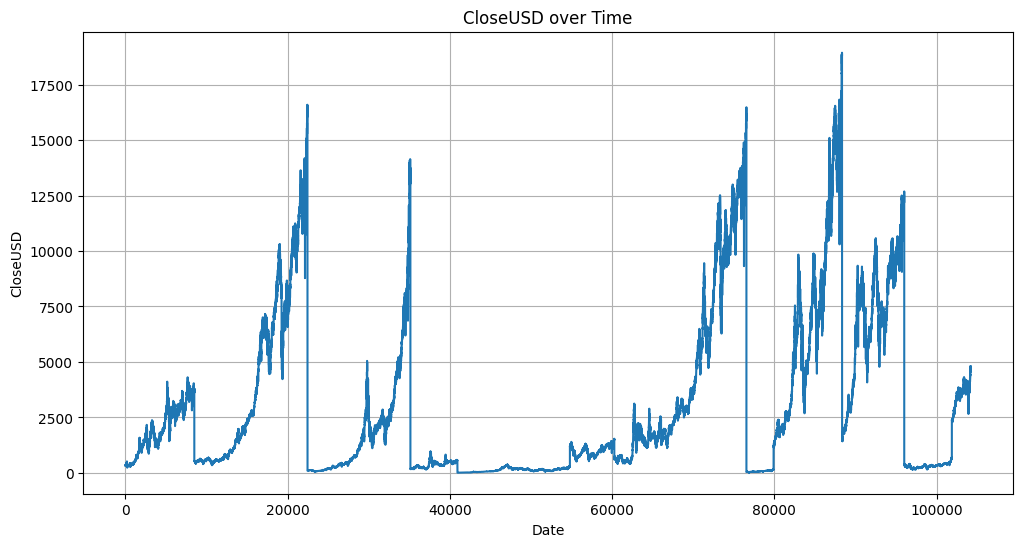

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['CloseUSD'])
plt.title('CloseUSD over Time')
plt.xlabel('Date')
plt.ylabel('CloseUSD')
plt.grid(True)
plt.show()

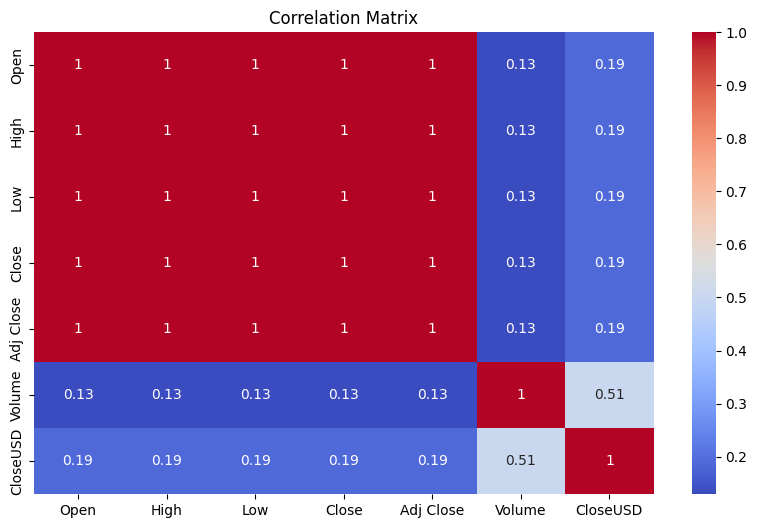

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Pembersihan dan Persiapan Data

Pada tahap ini dilakukan:
- Pemilihan subset data (misalnya hanya dari indeks tertentu seperti NSEI)
- Konversi tipe data tanggal
- Normalisasi fitur numerik menggunakan MinMaxScaler
- Pemisahan data menjadi data latih dan data uji


In [13]:
df_nsei = df[df['Index'] == 'NSEI']
df_nsei = df_nsei[['CloseUSD', 'Date']]

In [14]:
df_nsei['Date'] = pd.to_datetime(df_nsei['Date'])
df_nsei = df_nsei.sort_values('Date')
df_nsei.set_index('Date', inplace=True)

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_nsei['CloseUSD_scaled'] = scaler.fit_transform(df_nsei[['CloseUSD']])

In [16]:
result = adfuller(df_nsei['CloseUSD_scaled'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.6187345900461813
p-value: 0.9880684159456619


In [17]:
train_size = int(len(df_nsei) * 0.8)
train = df_nsei['CloseUSD_scaled'].iloc[:train_size]
test = df_nsei['CloseUSD_scaled'].iloc[train_size:]

# Modeling: Moving Average Forecasting

Model baseline yang digunakan adalah Moving Average dengan window size tetap. Dua pendekatan dilakukan:
- **Static Moving Average**: Menggunakan rata-rata terakhir dari data latih sebagai prediksi tetap.
- **Dynamic Moving Average**: Memperbarui prediksi setiap waktu berdasarkan rata-rata nilai terbaru.

Model ini digunakan sebagai pembanding awal sebelum dilakukan model machine learning yang lebih kompleks.


In [18]:
def moving_average(series, window):
    return series.rolling(window=window).mean()

window_size = 10

# prediksi harga besok = harga hari ini
forecast = df_nsei['CloseUSD_scaled'].shift(1)

# Ambil bagian forecast yang sejajar dengan test set
forecast_test = forecast.iloc[train_size:]
actual_test = test

In [19]:
history = list(train[-window_size:])  # Awali dengan window terakhir dari train
forecast_dynamic = []

for t in range(len(test)):
    ma_pred = np.mean(history[-window_size:])
    forecast_dynamic.append(ma_pred)
    history.append(test.iloc[t])  # Update history dengan data aktual setelah prediksi

forecast_dynamic = pd.Series(forecast_dynamic, index=test.index)

# Evaluation

Model dievaluasi menggunakan metrik:
- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)

Nilai ini digunakan untuk menilai seberapa besar kesalahan prediksi model terhadap data aktual.


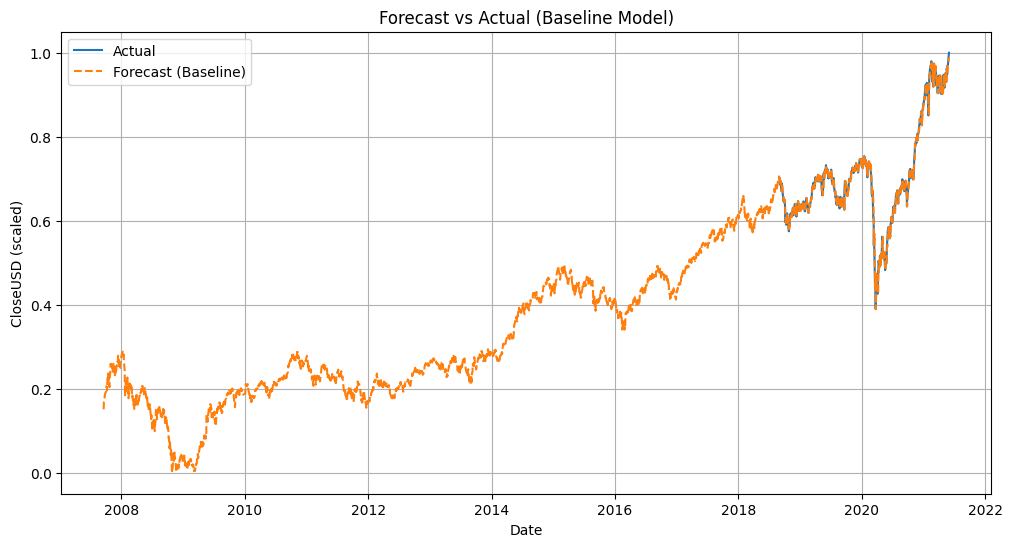

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(forecast.index, forecast.values, label='Forecast (Baseline)', linestyle='--')
plt.title('Forecast vs Actual (Baseline Model)')
plt.xlabel('Date')
plt.ylabel('CloseUSD (scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Hapus NaN pada awal forecast
valid_idx = forecast_test.dropna().index
mae = mean_absolute_error(actual_test.loc[valid_idx], forecast_test.loc[valid_idx])
rmse = np.sqrt(mean_squared_error(actual_test.loc[valid_idx], forecast_test.loc[valid_idx]))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE: 0.0081
RMSE: 0.0117


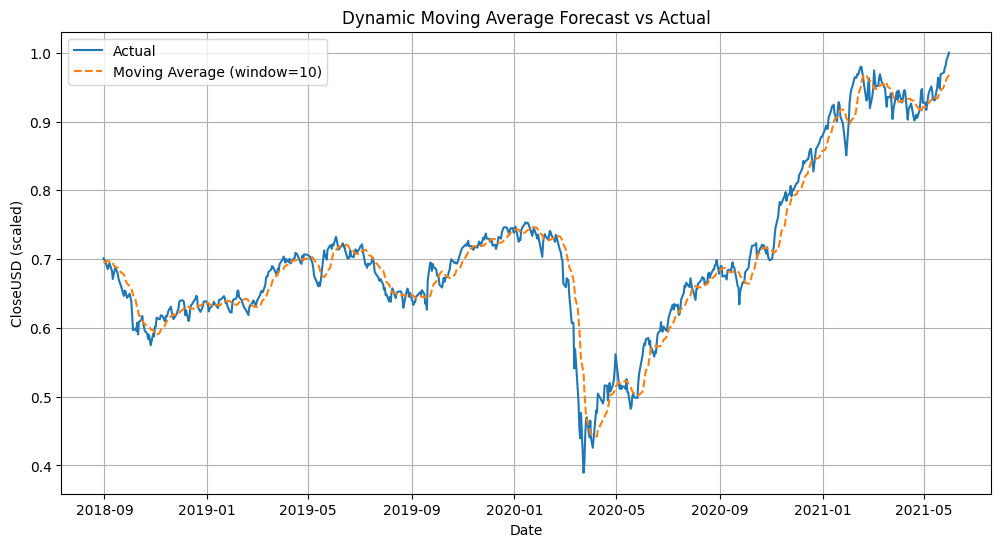

In [26]:
# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual')
plt.plot(forecast_dynamic.index, forecast_dynamic.values, label=f'Moving Average (window={window_size})', linestyle='--')
plt.title('Dynamic Moving Average Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('CloseUSD (scaled)')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Evaluasi
mae = mean_absolute_error(test, forecast_dynamic)
rmse = np.sqrt(mean_squared_error(test, forecast_dynamic))
print(f"MAE (Dynamic MA): {mae:.4f}")
print(f"RMSE (Dynamic MA): {rmse:.4f}")

MAE (Dynamic MA): 0.0164
RMSE (Dynamic MA): 0.0238


# Modeling dengan LSTM (Long Short-Term Memory)

Pada bagian ini, kita akan menggunakan model LSTM yang termasuk dalam arsitektur Recurrent Neural Network (RNN), sangat cocok untuk memproses data deret waktu seperti data harga saham.

Langkah-langkah:
1. Membuat windowing data time series sebagai input LSTM.
2. Membangun arsitektur model LSTM.
3. Melatih model menggunakan data latih.
4. Melakukan prediksi dan mengevaluasi performa menggunakan MAE dan RMSE.


In [25]:
# Import library
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Fungsi bantu untuk membuat dataset berjangka (window)
def create_dataset(series, look_back=10):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

# Parameter look_back
look_back = 10

# Buat dataset window
X_train, y_train = create_dataset(train.values, look_back)
X_test, y_test = create_dataset(test.values, look_back)

# Bentuk input menjadi [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Buat model LSTM
model = Sequential()
model.add(LSTM(units=50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Latih model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0328
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0054e-04
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7359e-04
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5438e-04
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6640e-04
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5607e-04
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5425e-04
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3833e-04
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3721e-04
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.4443e-04


In [24]:
# Prediksi dan evaluasi
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"LSTM MAE: {mae:.4f}")
print(f"LSTM RMSE: {rmse:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM MAE: 0.0183
LSTM RMSE: 0.0253


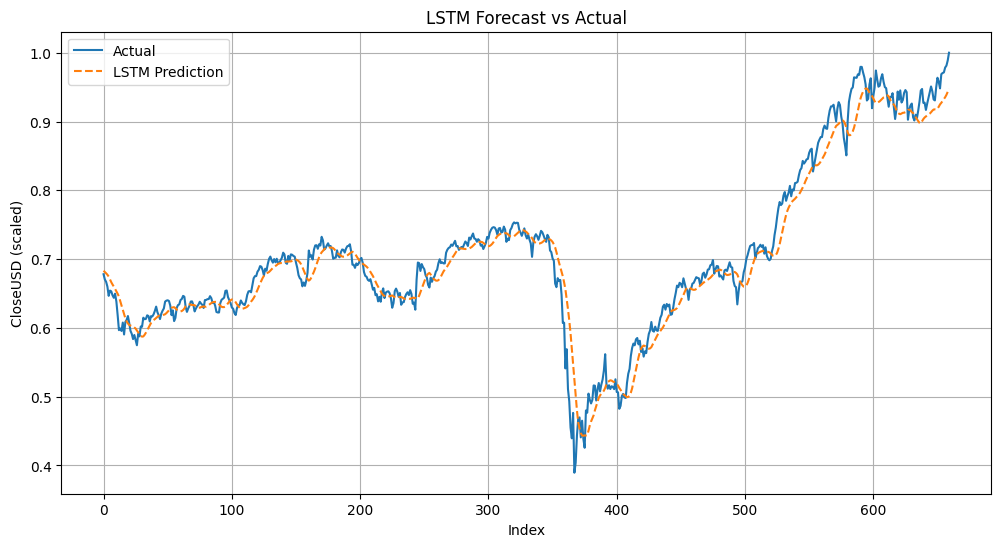

In [23]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='LSTM Prediction', linestyle='--')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Index')
plt.ylabel('CloseUSD (scaled)')
plt.legend()
plt.grid(True)
plt.show()